In [1]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
!pip install tifffile
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 93.3 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time
from tifffile import tifffile
import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to GPU


# Data Loading

In [3]:
ROWS, COLS = 32, 32

# Extract data from https://www.kaggle.com/datasets/kmader/siim-medical-images
data_zip = '/content/drive/MyDrive/Research/CTMedicalImages/archive.zip'

# extract the file
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

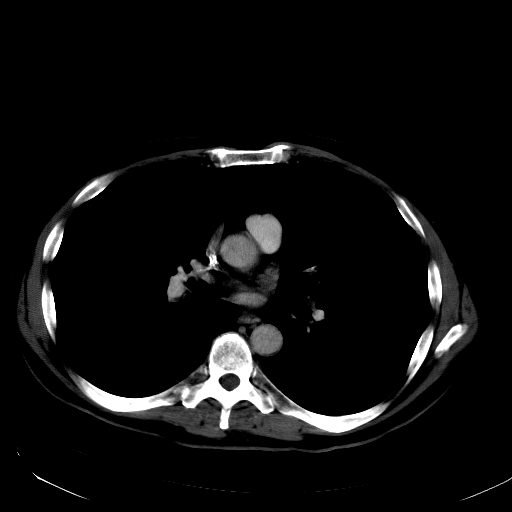

In [4]:
from google.colab.patches import cv2_imshow
overview_df = pd.read_csv('overview.csv')
overview_df.columns = ['id']+list(overview_df.columns[1:])
overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 1 if x else 0) #1 for contrast, 0 for no contrast
dummy_img = tifffile.imread(os.path.join('tiff_images', overview_df['tiff_name'][0]))
cv2_imshow(dummy_img)

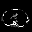

In [5]:
resized = cv2.resize(dummy_img, (ROWS, COLS),interpolation=cv2.INTER_CUBIC)
cv2_imshow(resized)

In [6]:
def read_tiff_and_resize(filepath, resize_row = 32, resize_col = 32):
  img = tifffile.imread(filepath)
  return cv2.resize(img, (resize_row, resize_col),interpolation=cv2.INTER_CUBIC)



class CTImgHermFlattened(torch.utils.data.Dataset):
    def __init__(self, overview_csv='overview.csv', tiff_img_folder='tiff_images', resize_col = 32, resize_row = 32):
        self.overview_df = pd.read_csv('overview.csv')
        self.overview_df.columns = ['idx']+list(overview_df.columns[1:])
        self.overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 1 if x else 0) #1 for contrast, 0 for no contrast
        self.resize_col = resize_col
        self.resize_row = resize_row

        self.data = []

        for i in range(len(self.overview_df)):
          img = read_tiff_and_resize(os.path.join(tiff_img_folder, overview_df['tiff_name'][i]), resize_row = self.resize_row , resize_col =self.resize_col).flatten()
          #img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
          img = img/np.linalg.norm(img)
          label = self.overview_df['Contrast'][i]
          self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

dummy_dataset = CTImgHermFlattened()
dummy_dataset[0]

(array([-0.0391611 , -0.0391611 , -0.0391611 , ..., -0.03758181,
        -0.0372378 , -0.0391611 ]),
 1)

# Construct the QCNN

![QCNN architecture, linked from Pennylane.](https://pennylane.ai/_images/qcnn-architecture.png)

We will follow the code in the Pennylane demo [Generalization in QML from few training data](https://pennylane.ai/qml/demos/tutorial_learning_few_data/) to construct our QCNN layers.

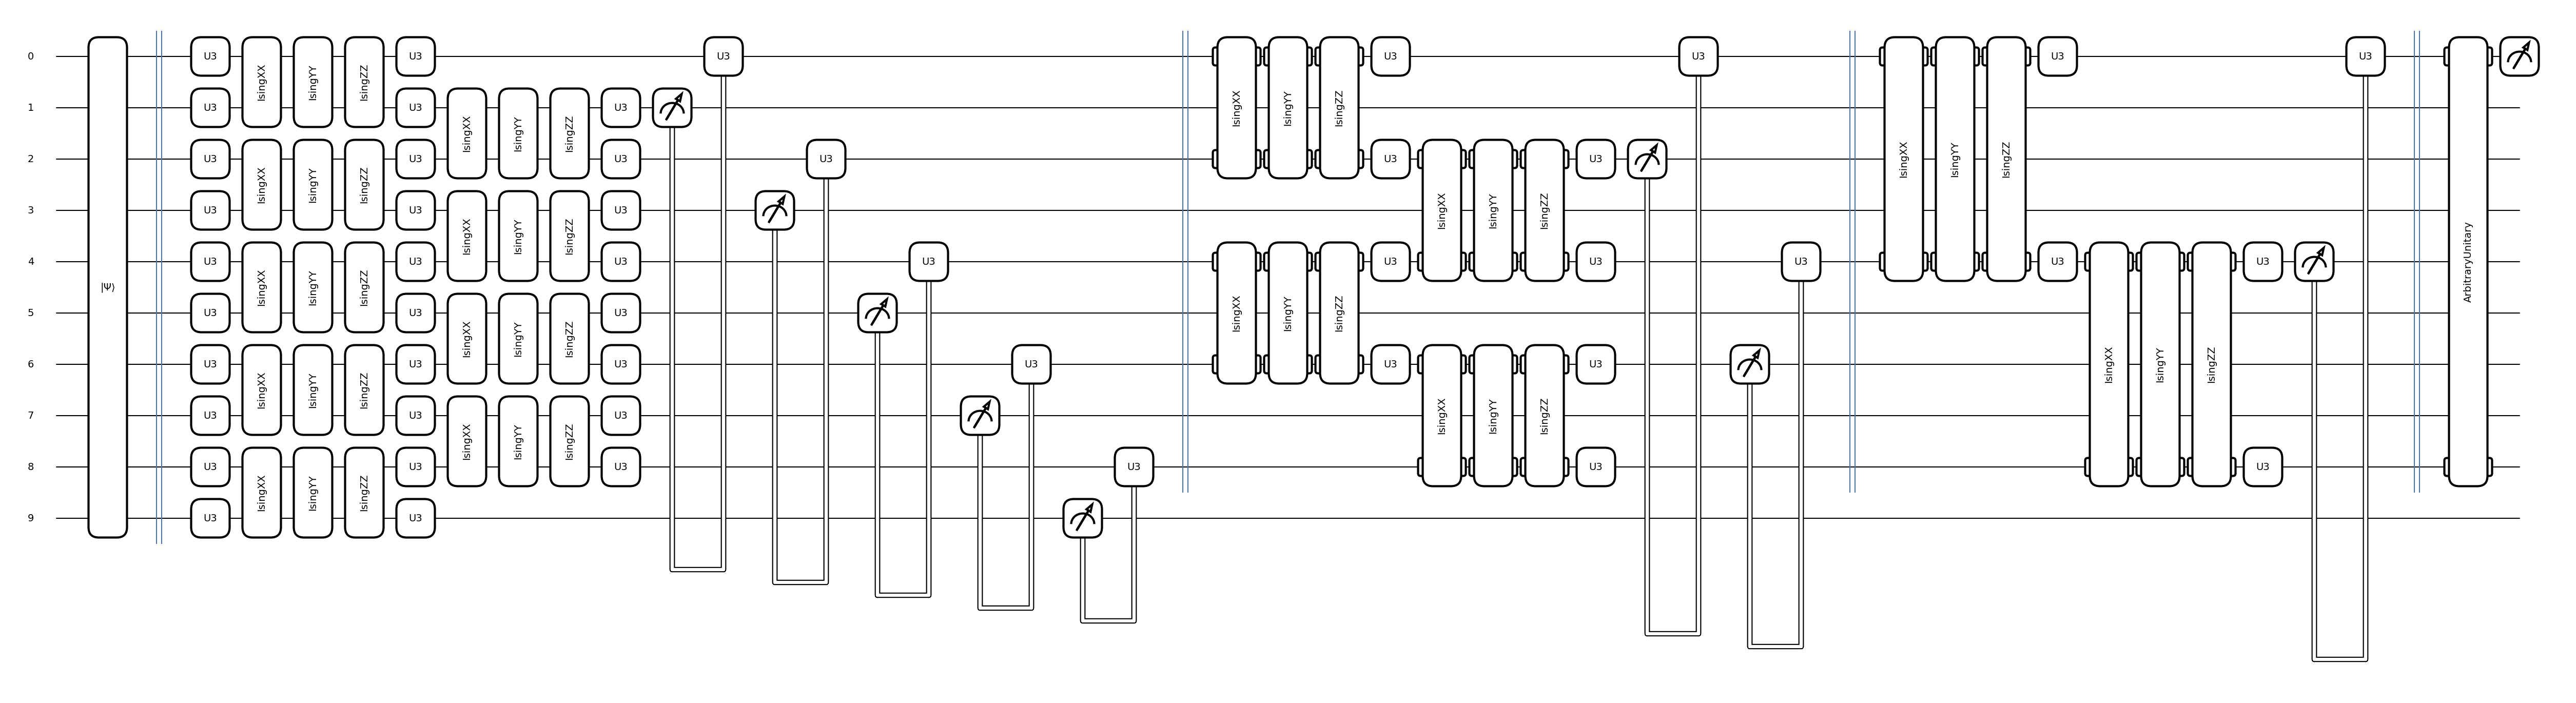

In [7]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])


def pooling_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])

def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""
    convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pooling_layer(kernel_weights[15:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    qml.ArbitraryUnitary(weights, wires)


num_wires = 10 # for 32 by 32 grey-scale images
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device, interface="jax")
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    return qml.probs(wires=(0))


fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(18, 3), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
)
plt.show()

# Training the QCNN with Flattened Image Data

In [8]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weights, weights_last, features, labels)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(18, 3), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [9]:
def train_qcnn(batchsize:int, n_epochs:int, seed:int = 1701):

    start = time.time()
    pnp.random.seed(seed)
    np.random.seed(seed)
    # load data
    full_dataset = CTImgHermFlattened()
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True
  )
    testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=True
  )

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(
        learning_rate=cosine_decay_scheduler,
        #b1=0.5,
        #b2=0.99999,
        #eps=1e-08,
        )
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        test_cost_batches = []
        test_acc_batches = []
        epoch_start = time.time()
        print(f"Training at Epoch {step+1}/{n_epochs}, Train size {len(trainloader)}, Test size {len(testloader)}......")
        for batch, (x_train, y_train) in enumerate(trainloader):
          batch_start = time.time()
          # Training step with (adam) optimizer
          x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
          train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
          updates, opt_state = optimizer.update(grad_circuit, opt_state)
          weights, weights_last = optax.apply_updates((weights, weights_last), updates)
          train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
          train_cost_batches.append(train_cost)
          train_acc_batches.append(train_acc)
          print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {train_cost}, Acc {train_acc}. Time {time.time()-batch_start}")


        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))


        # load test data
        for batch, (x_test, y_test) in enumerate(testloader):
          batch_start = time.time()
          x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
          # compute accuracy and cost on testing data
          test_out = compute_out(weights, weights_last, x_test, y_test)
          test_pred = jnp.argmax(test_out, axis=1)
          test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
          test_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
          test_cost_batches.append(test_cost)
          test_acc_batches.append(test_acc)
          print(f"Testing at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {test_cost}, Acc {test_acc}. Time {time.time()-batch_start}")
        test_acc_epochs.append(np.mean(test_acc_batches))
        test_cost = np.mean(test_cost_batches)
        test_cost_epochs.append(test_cost)
        print("......")
        print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step+1}/{n_epochs}, Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
        print("=-="*10)

    return dict(
        n_train=[train_size] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        test_cost=[c.astype(float) for c in test_cost_epochs],
        test_acc=[c.astype(float) for c in test_acc_epochs],
    )

In [10]:
n_epochs = 500
n_reps = 20
batch_size = 5000

train_sizes = [int(0.8 * len(CTImgHermFlattened()))]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qcnn(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Streaming output truncated to the last 5000 lines.
Epoch 286/500, Test: Cost 0.6895395822759238, Acc 0.5. Time 0.09042620658874512
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 287/500, Train size 1, Test size 1......
Training at Epoch 287/500, Batch 1, Cost 0.6537024316539619, Acc 0.75. Time 0.08045101165771484
Testing at Epoch 287/500, Batch 1, Cost 0.6894872046528304, Acc 0.5. Time 0.005162477493286133
......
Epoch 287/500, Train: Cost 0.6537024316539619, Acc 0.75
Epoch 287/500, Test: Cost 0.6894872046528304, Acc 0.5. Time 0.08976387977600098
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 288/500, Train size 1, Test size 1......
Training at Epoch 288/500, Batch 1, Cost 0.6536724496153765, Acc 0.7375. Time 0.08034920692443848
Testing at Epoch 288/500, Batch 1, Cost 0.6892786455562026, Acc 0.5. Time 0.005164146423339844
......
Epoch 288/500, Train: Cost 0.6536724496153765, Acc 0.7375
Epoch 288/500, Test: Cost 0.6892786455562026, Acc 0.5. Time 0.08972644805908203
=-==-==-==-==-==-

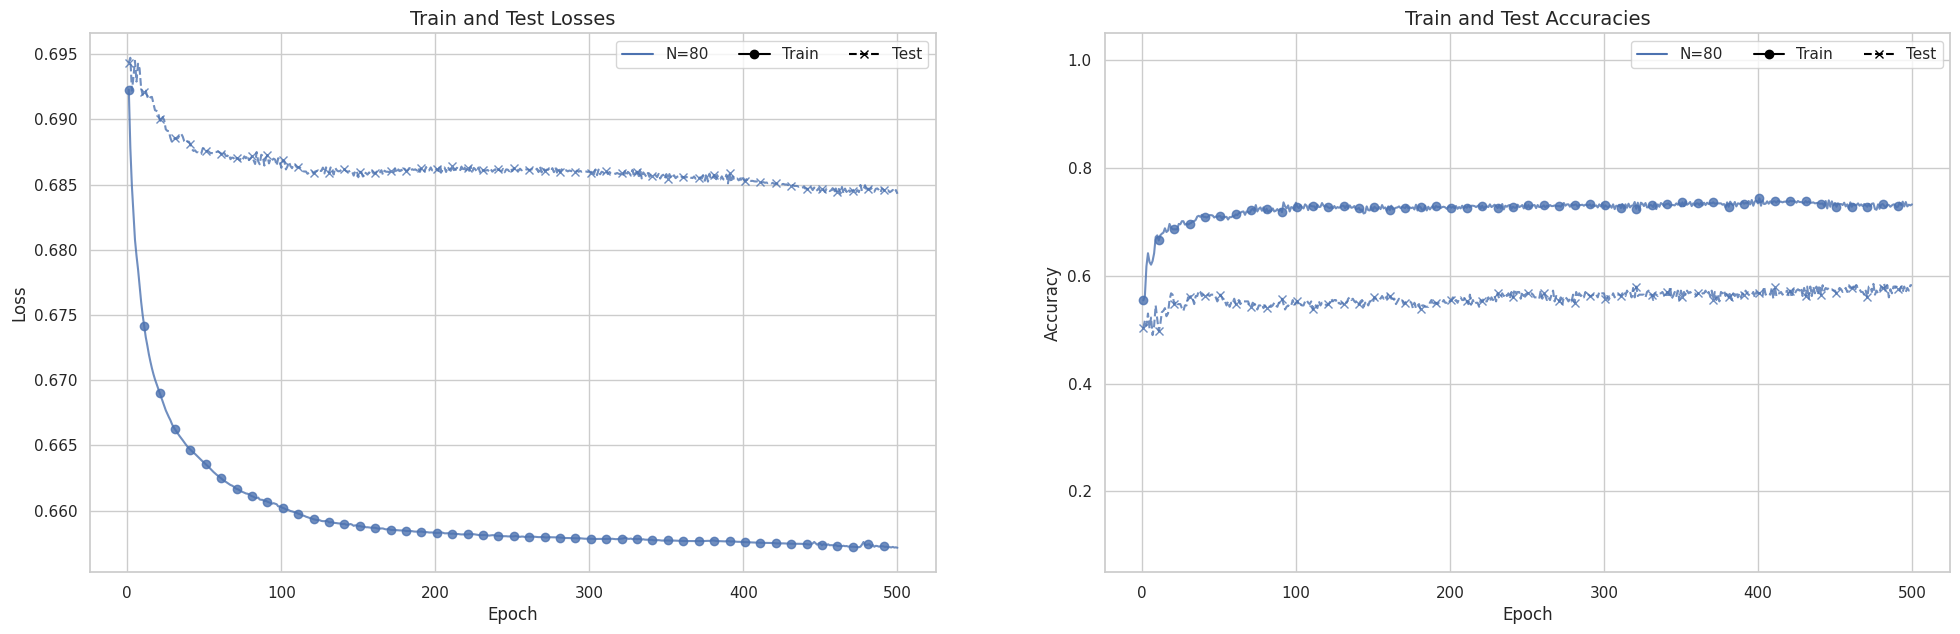

In [11]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(24, 7))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    #dif = df[df.step == n_epochs].test_cost["mean"] - df[df.step == n_epochs].train_cost["mean"]
    #generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
#ax = axes[1]
#ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
#ax.set_xscale('log')
#ax.set_xticks(train_sizes)
#ax.set_xticklabels(train_sizes)
#ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
#ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [12]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/ct-med-img"
results_df.to_csv(os.path.join(save_folder, "ct-med-img_baseline_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "ct-med-img_baseline_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "ct-med-img_baseline_results.pdf"))